In [28]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [29]:

URL="/content/historical_automobile_sales.csv"
df = pd.read_csv(URL)
print(df.dtypes)



Date                        object
Year                         int64
Month                       object
Recession                    int64
Consumer_Confidence        float64
Seasonality_Weight         float64
Price                      float64
Advertising_Expenditure      int64
Competition                  int64
GDP                        float64
Growth_Rate                float64
unemployment_rate          float64
Automobile_Sales           float64
Vehicle_Type                object
City                        object
dtype: object


In [30]:
#Cambio tipo de datos más apropiado
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Month'].astype('category')
df['Recession'] = df['Recession'].astype('category')
df['Competition'] = df['Competition'].astype('category')

print(df.dtypes)


Date                       datetime64[ns]
Year                                int64
Month                            category
Recession                        category
Consumer_Confidence               float64
Seasonality_Weight                float64
Price                             float64
Advertising_Expenditure             int64
Competition                      category
GDP                               float64
Growth_Rate                       float64
unemployment_rate                 float64
Automobile_Sales                  float64
Vehicle_Type                       object
City                               object
dtype: object


In [31]:
# Detectar valores nulos para cada columna y substituirlos por la media si es un valor numérico y por la moda si es un valor object o category.
# Si el número de valores nulos representa un % superior al 30%, eliminamos el valor nulo pero no el registro (que quede en blanco para que no interfiera el los cálculos estadísiticos)

def imputar_valores(df, umbral=0.30):
    df_copy = df.copy()
    num_filas = len(df_copy)

    for col in df_copy.columns:
        n_nulos = df_copy[col].isna().sum()
        pct_nulos = n_nulos / num_filas

        # Caso 1: numérico
        if pd.api.types.is_numeric_dtype(df_copy[col]):
            if pct_nulos < umbral:
                # Reemplazar por la media
                media = df_copy[col].mean()
                df_copy[col].fillna(media, inplace=True)
            # Si supera el umbral → no se toca (se deja NaN)

        # Caso 2: categórico u objeto
        elif pd.api.types.is_object_dtype(df_copy[col]) or pd.api.types.is_categorical_dtype(df_copy[col]):
            if pct_nulos < umbral:
                # Reemplazar por la moda
                moda = df_copy[col].mode()
                if len(moda) > 0: # por si el resultado vacío es el  más repetido
                    df_copy[col].fillna(moda.iloc[0], inplace=True)
            # Si supera el umbral → no se toca

    return df_copy


# Aplicarlo al dataframe
df_limpio = imputar_valores(df)



print("\nNulos por columna DESPUÉS de imputar:\n")
print(df_limpio.isna().sum())





Nulos por columna DESPUÉS de imputar:

Date                       0
Year                       0
Month                      0
Recession                  0
Consumer_Confidence        0
Seasonality_Weight         0
Price                      0
Advertising_Expenditure    0
Competition                0
GDP                        0
Growth_Rate                0
unemployment_rate          0
Automobile_Sales           0
Vehicle_Type               0
City                       0
dtype: int64


/tmp/ipython-input-3643431614.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(df_copy[col]) or pd.api.types.is_categorical_dtype(df_copy[col]):
/tmp/ipython-input-3643431614.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(media, inplace=True)
/tmp/ipython-input-3643431614.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through

In [32]:
#Reemplazar atípicos por Nan
def eliminar_outliers_iqr(df):
    df_clean = df.copy()
    cols_numericas = df_clean.select_dtypes(include=['number']).columns

    print("Reemplazando outliers en columnas numéricas por NaN...\n")

    for col in cols_numericas:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 1.5 * IQR
        lim_sup = Q3 + 1.5 * IQR

        # reemplaza solo los valores atípicos en la columna actual por NaN
        n_outliers = ((df_clean[col] < lim_inf) | (df_clean[col] > lim_sup)).sum()
        df_clean.loc[(df_clean[col] < lim_inf) | (df_clean[col] > lim_sup), col] = pd.NA

        print(f"{col}: reemplazados {n_outliers} valores atípicos")

    print("\nTotal de filas después de limpiar:", df_clean.shape[0])

    return df_clean

# Aplicarlo al dataframe
df_sin_outliers = eliminar_outliers_iqr(df_limpio)



Reemplazando outliers en columnas numéricas por NaN...

Year: reemplazados 0 valores atípicos
Consumer_Confidence: reemplazados 2 valores atípicos
Seasonality_Weight: reemplazados 0 valores atípicos
Price: reemplazados 4 valores atípicos
Advertising_Expenditure: reemplazados 0 valores atípicos
GDP: reemplazados 0 valores atípicos
Growth_Rate: reemplazados 28 valores atípicos
unemployment_rate: reemplazados 33 valores atípicos
Automobile_Sales: reemplazados 1 valores atípicos

Total de filas después de limpiar: 528


                             Year  Consumer_Confidence  Seasonality_Weight  \
Year                     1.000000            -0.020698            0.073834   
Consumer_Confidence     -0.020698             1.000000            0.025055   
Seasonality_Weight       0.073834             0.025055            1.000000   
Price                   -0.008345            -0.007519            0.007295   
Advertising_Expenditure -0.005397            -0.106665            0.005162   
GDP                      0.028012            -0.030770            0.002016   
Growth_Rate             -0.000024            -0.022800           -0.018991   
unemployment_rate       -0.164129             0.000418           -0.164237   
Automobile_Sales         0.202922             0.004989            0.121759   

                            Price  Advertising_Expenditure       GDP  \
Year                    -0.008345                -0.005397  0.028012   
Consumer_Confidence     -0.007519                -0.106665 -0.030770   
Sea

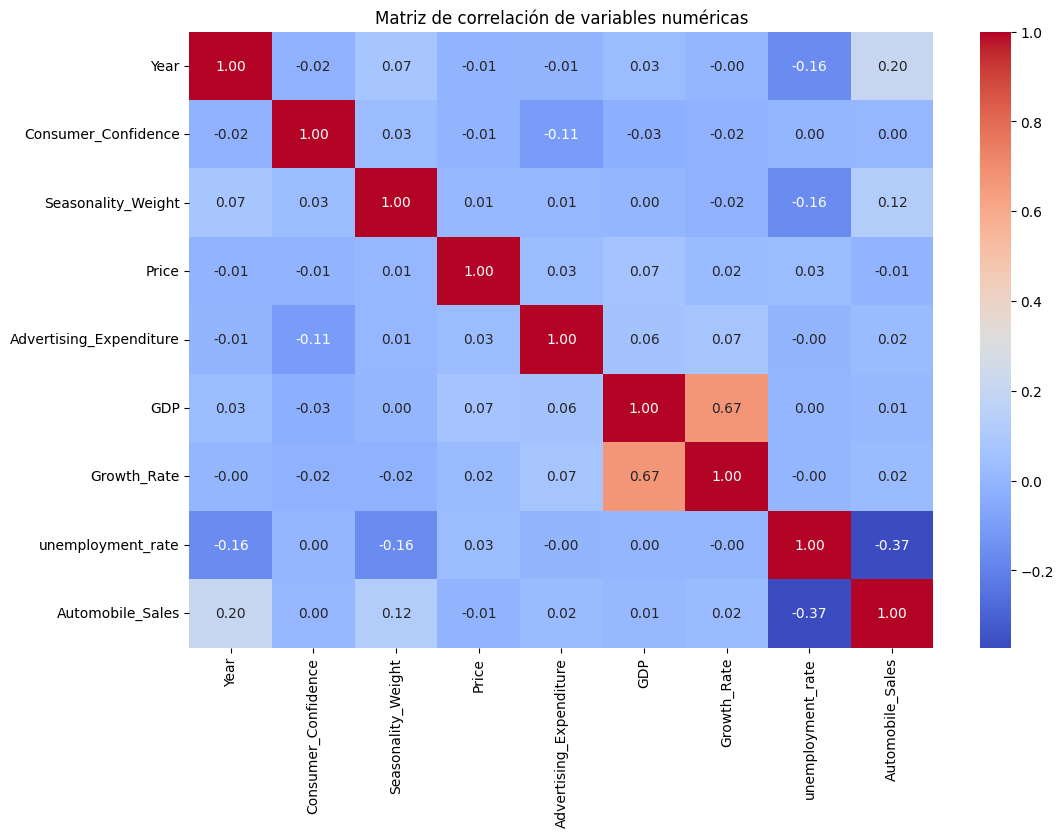

In [33]:
# Matriz de correlación numérica
corr = df_sin_outliers.corr(numeric_only=True)

# Mostrar la matriz
print(corr)

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación de variables numéricas")
plt.show()

/tmp/ipython-input-1136959593.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_vector.values, y=corr_vector.index, palette="coolwarm")


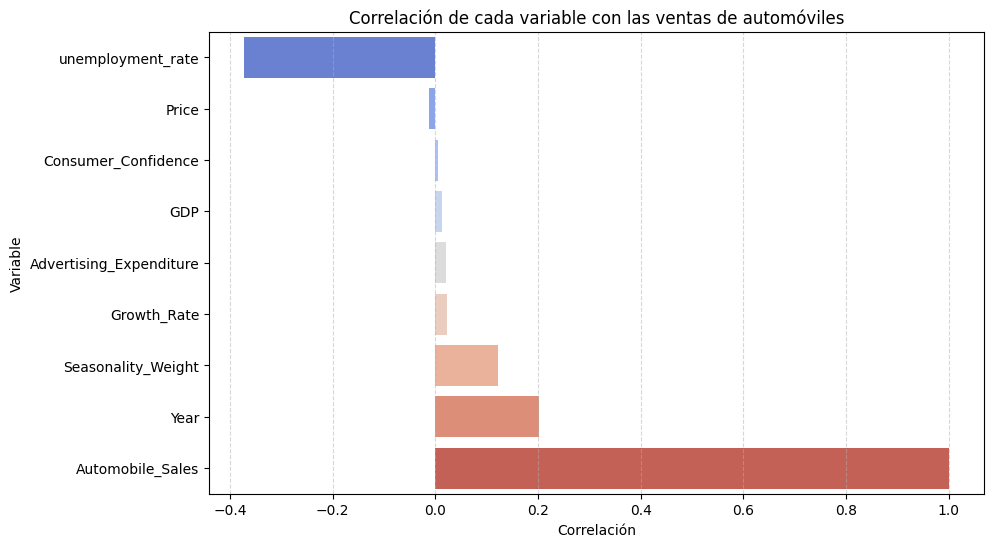

In [34]:
# Matriz bidimiensional correlación variables numéricas y ventas
corr_vector = df_sin_outliers.corr(numeric_only=True)["Automobile_Sales"].sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_vector.values, y=corr_vector.index, palette="coolwarm")
plt.title("Correlación de cada variable con las ventas de automóviles")
plt.xlabel("Correlación")
plt.ylabel("Variable")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

In [35]:
# Tipo de vehículo más vendido por ciudad
ventas_por_ciudad = (
    df_sin_outliers.groupby(["City", "Vehicle_Type"])["Automobile_Sales"]
    .sum()
    .reset_index()
)

# Para cada ciudad, seleccionar el vehículo con más ventas
vehiculo_top_ciudad = (
    ventas_por_ciudad.loc[ventas_por_ciudad.groupby("City")["Automobile_Sales"].idxmax()]
    .sort_values("City")
)

print(vehiculo_top_ciudad)

          City     Vehicle_Type  Automobile_Sales
2   California  Smallfamiliycar          74420.00
6      Georgia  Mediumfamilycar         105362.54
11    Illinois  Mediumfamilycar          87317.30
16    New York  Mediumfamilycar         116334.10


In [36]:
#Ventas por ciudad y tipo de vehículo
# Agrupar por ciudad y tipo de vehículo, sumando ventas
ventas_por_ciudad = df_sin_outliers.groupby(["City", "Vehicle_Type"])["Automobile_Sales"].sum().reset_index()

# Calcular el total de ventas por ciudad
total_por_ciudad = ventas_por_ciudad.groupby("City")["Automobile_Sales"].transform("sum")

# Calcular porcentaje
ventas_por_ciudad["Porcentaje_Ventas"] = (ventas_por_ciudad["Automobile_Sales"] / total_por_ciudad) * 100

# Ordenar por ciudad y porcentaje descendente
ventas_por_ciudad = ventas_por_ciudad.sort_values(["City", "Porcentaje_Ventas"], ascending=[True, False])

print(ventas_por_ciudad)

          City     Vehicle_Type  Automobile_Sales  Porcentaje_Ventas
2   California  Smallfamiliycar          74420.00          26.722203
1   California  Mediumfamilycar          67888.90          24.377062
3   California           Sports          60972.90          21.893714
0   California     Executivecar          49739.10          17.859962
4   California    Supperminicar          25474.10           9.147058
6      Georgia  Mediumfamilycar         105362.54          36.279538
8      Georgia           Sports          66180.20          22.787862
7      Georgia  Smallfamiliycar          61039.30          21.017694
5      Georgia     Executivecar          31977.20          11.010726
9      Georgia    Supperminicar          25859.40           8.904181
11    Illinois  Mediumfamilycar          87317.30          27.337230
13    Illinois           Sports          73860.80          23.124280
12    Illinois  Smallfamiliycar          69042.70          21.615833
14    Illinois    Supperminicar   

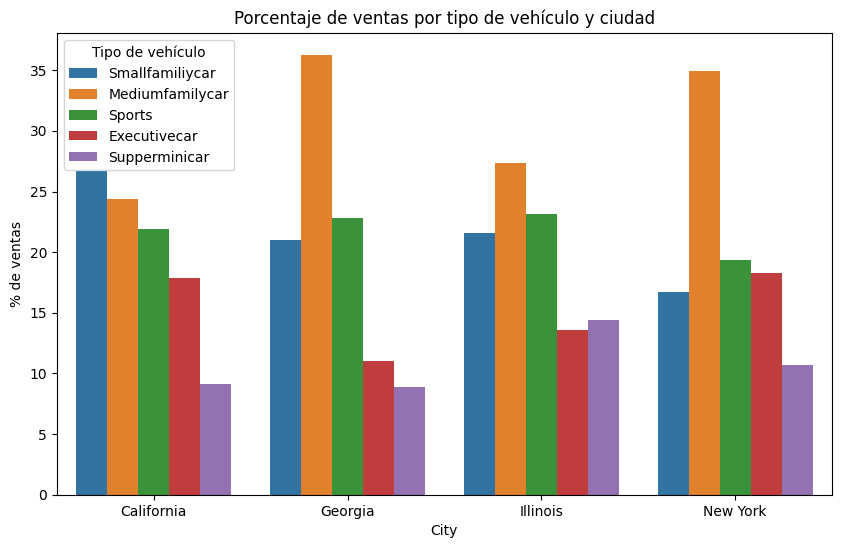

In [37]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=ventas_por_ciudad,
    x="City",
    y="Porcentaje_Ventas",
    hue="Vehicle_Type",
)
plt.ylabel("% de ventas")
plt.title("Porcentaje de ventas por tipo de vehículo y ciudad")
plt.legend(title="Tipo de vehículo")
plt.show()